In [1]:
from train import *

In [2]:
all_data = tf.contrib.learn.datasets.base.load_csv_without_header(
      filename='micro_data.csv',
      target_dtype=np.float32,
      features_dtype=np.float32)

In [3]:
X = all_data.data 
y = all_data.target

In [4]:
X = np.delete(X, [15, 16], 1)

In [5]:
X = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, keepdims=True)

In [6]:
y_std = np.std(y)
y_mean = np.mean(y)
y = (y - y_mean) / y_std

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

def build_model(no_layers=2, no_units=100, dropout=0.6):
    model = Sequential()
    model.add(Dense(no_units, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    
    for i in range(no_layers - 1):
        model.add(Dense(no_units, activation='relu'))
        model.add(Dropout(dropout))
        model.add(BatchNormalization())
        
    model.add(Dense(1))
    model.compile(loss='mae', metrics=[], optimizer=Adam(lr=0.001))
    return model

Using TensorFlow backend.


In [8]:
model = build_model(dropout=0.4)

In [9]:
def train_test_split(X, y, train_ratio):
    h = np.random.permutation(X.shape[0])
    n_train = int(train_ratio * X.shape[0])
    X_train = X[h[:n_train], :]
    X_test = X[h[n_train:], :]
    y_train = y[h[:n_train]]
    y_test = y[h[n_train:]]
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 0.8)

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=8192, verbose=0)

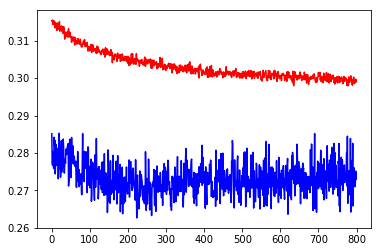

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['loss'][200:], c='red')
plt.plot(history.history['val_loss'][200:], c='blue')

In [13]:
def get_errors(actual, predicted):
    actual = actual.flatten()
    predicted = predicted.flatten()
    actual = actual * y_std + y_mean
    predicted = predicted * y_std + y_mean
    error = np.abs(actual - predicted)
    rel_error = np.abs(actual - predicted) / actual
    return np.max(error), np.mean(error), np.max(rel_error), np.mean(rel_error)

In [14]:
predicted = model.predict(X_test)
get_errors(y_test, predicted)

(6265.668, 1186.489, 0.14562233, 0.025855351)

In [15]:
predicted = model.predict(X_train)
get_errors(y_train, predicted)

(7219.0195, 1174.8094, 0.16073789, 0.025601285)